# Filtering and Preprocessing
We have some GPS data of a vehicle driving around munich for a few weeks. The data is recorded with a smartphone app, that should detect if the vehicle is driving to trigger a record. This dosn't work every time, therefore we need to find and remove points where the vehicle is not driving. When driving in cities the GPS signal isn't that good all the time as well. So we need to find out when a signal is bad and remove this points.

Let's start importing the modules

In [1]:
import pandas as pd, geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapely import wkb
import mplleaflet
import sys
import pickle
# import additional functions
%run ./data/custom_functions.py



In [2]:
# get the raw data from the smartphone. This is prepared in a geopandas dataframe with all the gps Points converted as shapely points
data = pd.read_pickle('data/gps_data.p')

In [3]:
# First display the data we got. 
display(data)

,time,altitude,course,hdop,vdop,speed,geom
0,2015-01-12 06:21:54,619.0,82.1,3.0,3.0,12.25,POINT (11.27812 48.157087)
1,2015-01-12 06:21:55,619.0,92.0,3.0,3.0,12.75,POINT (11.278284 48.157082)
2,2015-01-12 06:21:56,619.0,100.8,3.0,3.0,14.00,POINT (11.278472 48.157058)
3,2015-01-12 06:21:57,619.0,102.6,3.0,3.0,14.50,POINT (11.278666 48.157031)
4,2015-01-12 06:21:58,619.0,103.5,3.0,3.0,14.00,POINT (11.278848 48.157002)
...,...,...,...,...,...,...,...
160353,2015-01-15 19:38:28,601.0,0.0,4.0,4.0,0.00,POINT (11.168952 48.164704)
160354,2015-01-15 19:38:29,602.0,0.0,3.0,3.0,0.00,POINT (11.168957 48.164703)
160355,2015-01-15 19:38:30,602.0,0.0,4.0,4.0,0.00,POINT (11.168957 48.164703)
160356,2015-01-15 19:38:31,601.0,0.0,3.0,3.0,0.00,POINT (11.16896 48.164703)


## Preparing data for filtering
The first task will be to find and remove points indicationg a error in measurement.    
Find some aspects that can indicate these errors if you have a time series of GPS points as database.

In [4]:
# Aspects incdication measurment error


No we precalculate some values between two conscutive data points, that we will need several times.    
- Time difference
- Distance
- Speed difference = Acceleration
- Speed from Distance difference (for comparison)

For distance calculation between two points there aready is a function given in 'custom_functiions.py'. It Return the distance in meter.

    lat_lon_2_m(latitude_1, longitude_1, latitude_2, longitude_2)    
    
Write a function to calculate the distance of all datapoints in the geopandas dataframe. 
Hint: 

    You can access the longitude/latitude with .x /.y on the geometry object.

In [5]:
def calculate_distance_points(points):
    # initialize distance array
    distance = np.zeros(len(points))
    # loop all points
    for i in range(0, len(points) - 1):
        # calculate distance between two consecutive points using lat_lon_2_km function
        d = lat_lon_2_m(
            points[i].x,
            points[i].y,
            points[i+1].x,
            points[i+1].y,)
        # append distance to array
        distance[i + 1] = d
    return distance

In [6]:
# calculate time difference between points using pandas.shift() function
data['time_diff'] = data.time-data.time.shift(1,fill_value = 0)
data['distance_diff'] = calculate_distance_points(data.geom)
# calculate distance between a point and the one following in meter
data['acceleration'] = (data.speed-data.speed.shift())/(data.time_diff.dt.total_seconds())
# for comparison get the speed and acceleration values from the positions and thime between them
data['speed_calc'] = (data.distance_diff/(data.time_diff.dt.total_seconds()))

In [7]:
print(data.head(10))

                 time  altitude  course  hdop  vdop  speed  \
0 2015-01-12 06:21:54     619.0    82.1   3.0   3.0  12.25   
1 2015-01-12 06:21:55     619.0    92.0   3.0   3.0  12.75   
2 2015-01-12 06:21:56     619.0   100.8   3.0   3.0  14.00   
3 2015-01-12 06:21:57     619.0   102.6   3.0   3.0  14.50   
4 2015-01-12 06:21:58     619.0   103.5   3.0   3.0  14.00   
5 2015-01-12 06:21:59     619.0   105.4   3.0   3.0  13.25   
6 2015-01-12 06:22:00     619.0   109.3   3.0   3.0  12.75   
7 2015-01-12 06:22:01     619.0   113.5   4.0   4.0  12.50   
8 2015-01-12 06:22:02     618.0   117.6   3.0   3.0  12.25   
9 2015-01-12 06:22:03     618.0   116.9   3.0   3.0  12.25   

                          geom           time_diff  distance_diff  \
0   POINT (11.27812 48.157087) 16447 days 06:21:54       0.000000   
1  POINT (11.278284 48.157082)     0 days 00:00:01      18.244143   
2  POINT (11.278472 48.157058)     0 days 00:00:01      21.067865   
3  POINT (11.278666 48.157031)     0 days

In [17]:
print(data.iloc[1699])
print("------")
print(data.iloc[1700])
print("------")
print(data.iloc[1701])
print("------")
print(data.iloc[1702])


time                     2015-01-12 06:50:16
altitude                                 597
course                                     0
hdop                                       5
vdop                                       5
speed                                      0
geom             POINT (11.533656 48.137337)
time_diff                    0 days 00:00:01
distance_diff                              0
acceleration                               0
speed_calc                                 0
Name: 1699, dtype: object
------
time                     2015-01-12 06:50:17
altitude                                 597
course                                     0
hdop                                       5
vdop                                       5
speed                                      0
geom             POINT (11.533656 48.137337)
time_diff                    0 days 00:00:01
distance_diff                              0
acceleration                               0
speed_calc            

In [18]:
# display rows where the time difference is bigger than one minute. The time difference needs to be a timeDelta object.
display(data[data.time_diff > np.timedelta64(1, 'm')])

,time,altitude,course,hdop,vdop,speed,geom,time_diff,distance_diff,acceleration,speed_calc
0,2015-01-12 06:21:54.000,619.0,82.1,3.0,3.0,12.25,POINT (11.27812 48.157087),16447 days 06:21:54,0.000000,NaN,0.000000
1701,2015-01-12 07:02:04.773,596.0,223.8,9.0,9.0,3.00,POINT (11.533619 48.137255),0 days 00:11:47.773000,9.835702,0.004239,0.013897
17193,2015-01-12 16:39:48.000,556.0,214.6,3.0,3.0,6.50,POINT (11.530487 48.17138),0 days 05:19:32,3715.206347,0.000339,0.193783
17531,2015-01-12 16:46:29.000,603.0,115.6,75.0,75.0,22.75,POINT (11.538157 48.145248),0 days 00:01:04,1037.380970,0.308594,16.209078
18155,2015-01-12 18:31:33.000,638.0,246.0,7.0,7.0,2.50,POINT (11.533552 48.137236),0 days 01:34:33,24.679084,0.000441,0.004350
19680,2015-01-12 19:00:16.000,610.0,328.7,3.0,3.0,15.75,POINT (11.284498 48.156603),0 days 00:03:15,700.118335,0.080769,3.590350
20531,2015-01-13 06:09:18.000,584.0,119.8,5.0,5.0,14.51,POINT (11.200234 48.142067),0 days 10:54:52,4271.712288,0.000369,0.108717
22804,2015-01-13 07:55:49.000,609.0,352.0,4.0,4.0,3.25,POINT (11.533669 48.137444),0 days 01:08:30,11.828197,0.000791,0.002878
24955,2015-01-13 08:33:06.000,591.0,355.7,4.0,4.0,3.75,POINT (11.533795 48.137422),0 days 00:01:18,9.148540,0.048077,0.117289
29977,2015-01-13 09:58:53.602,565.0,0.0,4.0,4.0,0.00,POINT (11.528638 48.155767),0 days 00:02:05.602000,0.111195,0.000000,0.000885


In [19]:
print(data.head(20))

                  time  altitude  course  hdop  vdop  speed  \
0  2015-01-12 06:21:54     619.0    82.1   3.0   3.0  12.25   
1  2015-01-12 06:21:55     619.0    92.0   3.0   3.0  12.75   
2  2015-01-12 06:21:56     619.0   100.8   3.0   3.0  14.00   
3  2015-01-12 06:21:57     619.0   102.6   3.0   3.0  14.50   
4  2015-01-12 06:21:58     619.0   103.5   3.0   3.0  14.00   
5  2015-01-12 06:21:59     619.0   105.4   3.0   3.0  13.25   
6  2015-01-12 06:22:00     619.0   109.3   3.0   3.0  12.75   
7  2015-01-12 06:22:01     619.0   113.5   4.0   4.0  12.50   
8  2015-01-12 06:22:02     618.0   117.6   3.0   3.0  12.25   
9  2015-01-12 06:22:03     618.0   116.9   3.0   3.0  12.25   
10 2015-01-12 06:22:04     618.0   115.5   4.0   4.0  12.00   
11 2015-01-12 06:22:05     618.0   114.3   3.0   3.0  12.25   
12 2015-01-12 06:22:06     618.0   107.9   3.0   3.0  11.75   
13 2015-01-12 06:22:07     618.0   103.6   4.0   4.0  11.25   
14 2015-01-12 06:22:08     617.0    96.8   4.0   4.0  1

In [21]:
# compare speed from GPS vs speed claculated from distance/time
def rsme(predictions,targets):
    return np.sqrt(np.mean((predictions-targets)**2))

# Inser your code here...
for i in range(len(data)):
#     print("predictions: {}".format(data.iloc[i].speed_calc))
#     print("targest: {}".format(data.iloc[i].speed))
#     print("difference:" + str(rsme(data.iloc[i].speed_calc, data.iloc[i].speed)))
#     print("------")
    if rsme(data.iloc[i].speed_calc, data.iloc[i].speed) > 20:
        print("number of %s" %i)
        print("predictions: {}".format(data.iloc[i].speed_calc))
        print("targest: {}".format(data.iloc[i].speed))
        print("difference:" + str(rsme(data.iloc[i].speed_calc, data.iloc[i].speed)))
        print("------")


number of 17539
predictions: 100.25657810667768
targest: 3.0
difference:97.25657810667768
------
number of 17540
predictions: 102.80047424364858
targest: 14.25
difference:88.55047424364858
------
number of 17541
predictions: 305.543581957075
targest: 46.75
difference:258.793581957075
------
number of 17542
predictions: 240.80720711041712
targest: 68.5
difference:172.30720711041712
------
number of 17549
predictions: 27.145538614800195
targest: 50.25
difference:23.104461385199805
------
number of 17550
predictions: 25.415059506831597
targest: 46.25
difference:20.834940493168403
------
number of 17551
predictions: 17.247151143479236
targest: 42.0
difference:24.752848856520764
------
number of 17552
predictions: 28.15270403790153
targest: 3.0
difference:25.15270403790153
------
number of 17553
predictions: 169.2141159473555
targest: 3.25
difference:165.9641159473555
------
number of 17554
predictions: 42.995381839625495
targest: 3.25
difference:39.745381839625495
------
number of 18753
pr

# Filter values with low speed
Remove rows from data where speed is near zero. But let's visualize the current speed distribution by a KDE Plot.    
Hint: 

    You can use the plotting function integrated in pandas for a quick plot. 
    Parameters are explained in the soure.
    https://github.com/pandas-dev/pandas/blob/v0.25.1/pandas/plotting/_core.py#L504-L1533

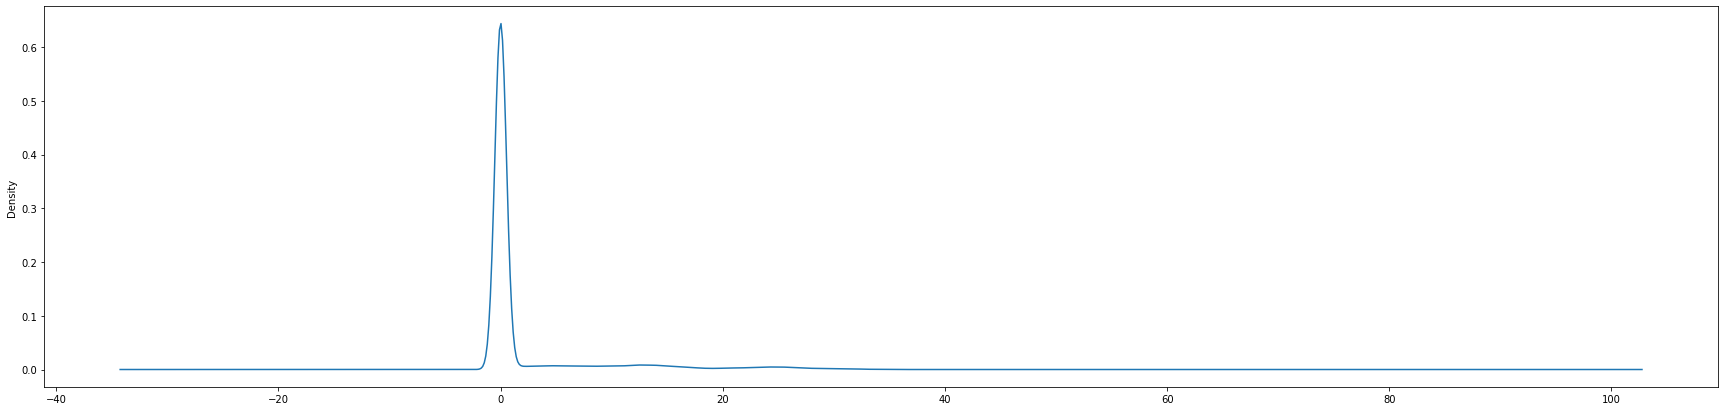

In [22]:

# Plot the KDE before removing the near zero values
data['speed'].plot.kde(figsize = (30,7))


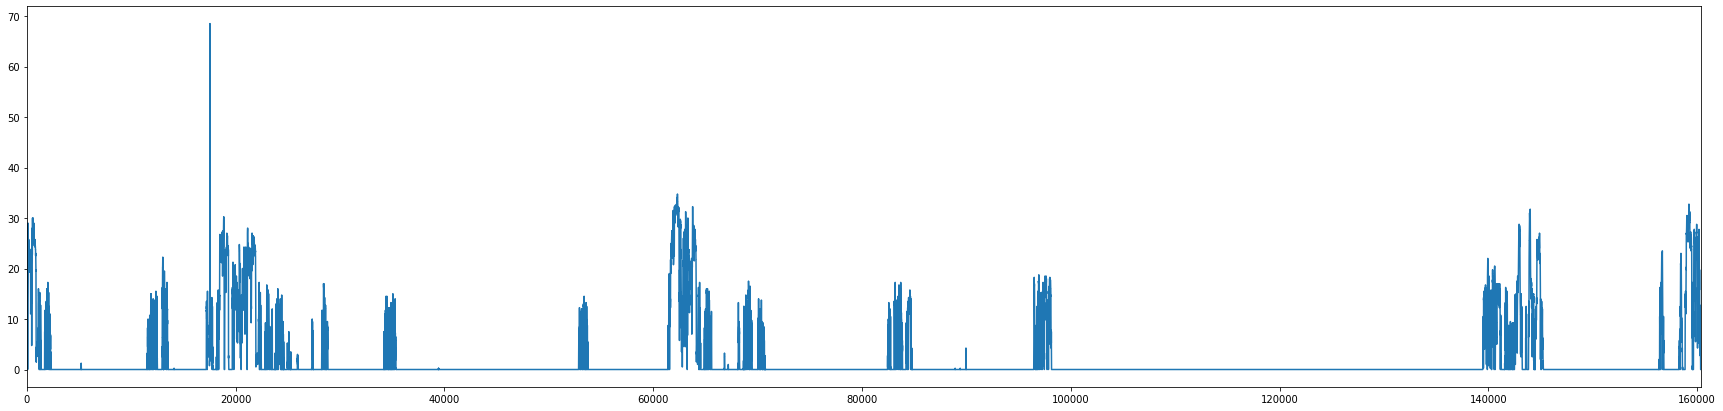

In [23]:
data.speed.plot(figsize = (30,7))

Plot some points with very low speed on a map. How do they behave?    
Hint:

    Use the prepared function 'map_folium' for plotting a dataframe.
    map_folium(pos_data, colorvalue, geometry = 'geom', c_min = -1, c_max = -1, line = False, cm_type='jet')
    take a subset of the data to make it printable (max. 6500 points) by conditional filtering (see link below for examples)
    https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/

In [24]:
condition = (data.time > '2015-01-14 14:05:29.748') & (data.time < '2015-01-14 16:28:26.000') & (data.speed < 1)
map_folium(data[condition], 'speed')

Rendering 6364 Points


In [25]:
# Filter Data
# Select a threshold value for clipping points by speed
speed_thr = 0.1 # m/s
# First calculate a filtered speed with a rolling window of 10 seconds. This prevents short stops to be removed
data['speed_median']= data['speed'].rolling(3).median()

#apply filter
data = data[data.speed_median > speed_thr]

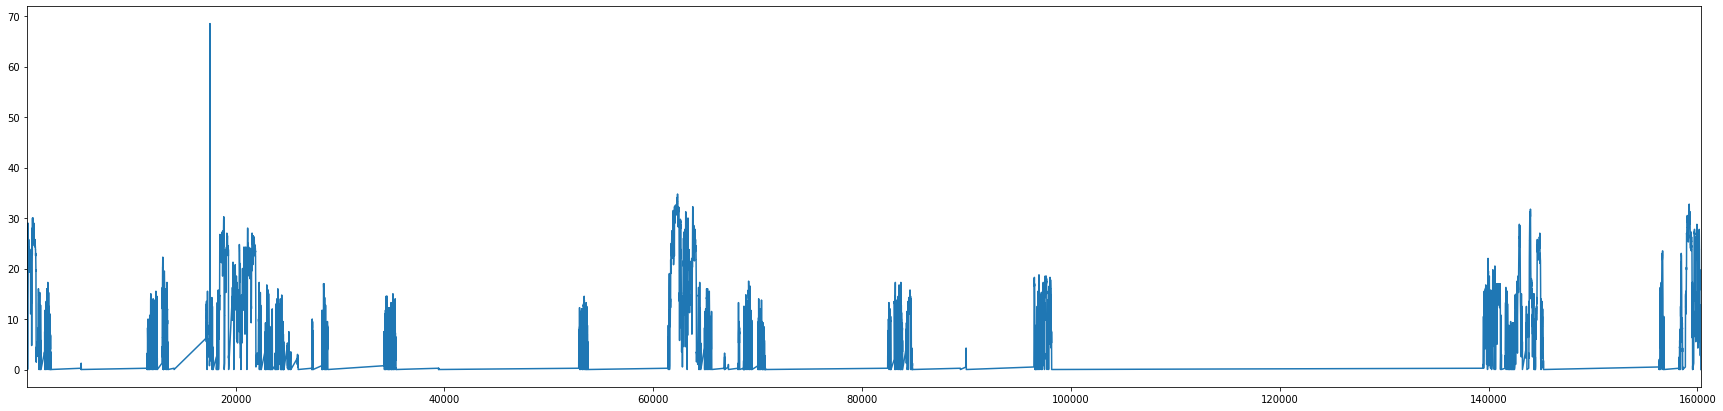

In [26]:
data.speed.plot(figsize = (30,7))

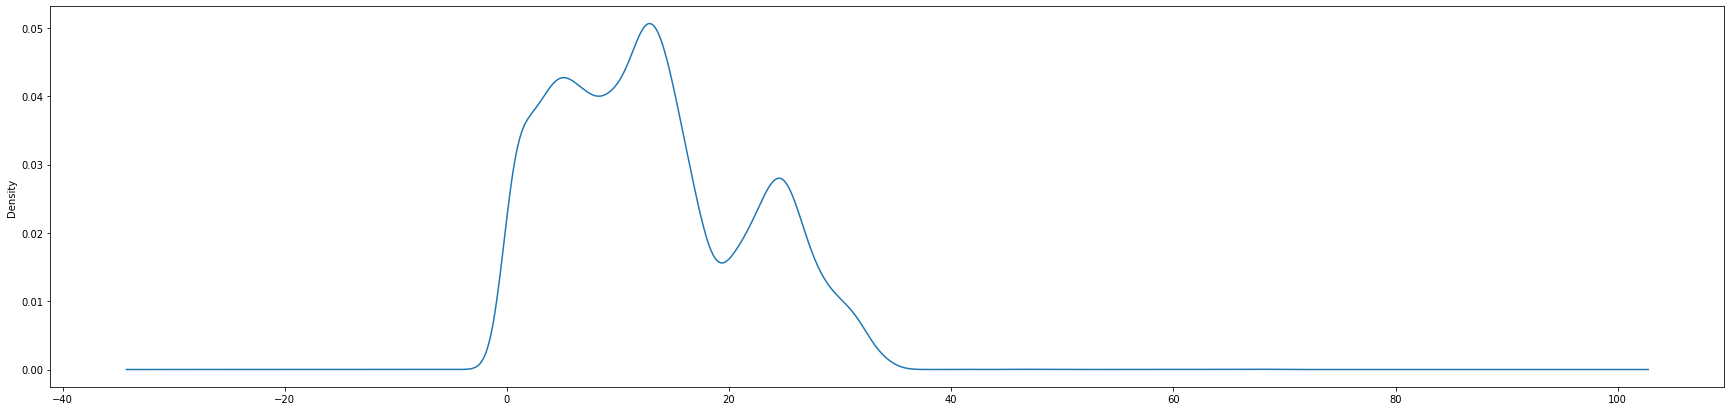

In [27]:
# Plot the KDE after removing the near zero values
data['speed'].plot.kde(figsize = (30,7))


In [28]:
print(len(data))

25031


In [29]:
print(data.head(10))

                  time  altitude  course  hdop  vdop  speed  \
2  2015-01-12 06:21:56     619.0   100.8   3.0   3.0  14.00   
3  2015-01-12 06:21:57     619.0   102.6   3.0   3.0  14.50   
4  2015-01-12 06:21:58     619.0   103.5   3.0   3.0  14.00   
5  2015-01-12 06:21:59     619.0   105.4   3.0   3.0  13.25   
6  2015-01-12 06:22:00     619.0   109.3   3.0   3.0  12.75   
7  2015-01-12 06:22:01     619.0   113.5   4.0   4.0  12.50   
8  2015-01-12 06:22:02     618.0   117.6   3.0   3.0  12.25   
9  2015-01-12 06:22:03     618.0   116.9   3.0   3.0  12.25   
10 2015-01-12 06:22:04     618.0   115.5   4.0   4.0  12.00   
11 2015-01-12 06:22:05     618.0   114.3   3.0   3.0  12.25   

                           geom time_diff  distance_diff  acceleration  \
2   POINT (11.278472 48.157058)  00:00:01      21.067865          1.25   
3   POINT (11.278666 48.157031)  00:00:01      21.771848          0.50   
4   POINT (11.278848 48.157002)  00:00:01      20.483097         -0.50   
5    POINT

# Filter GPS outliers
Filter out points with bad signal quality index (Horizontal Dilution of precision = HDOP)    

| DOP Value | Rating    | Description                                                                                                                                                                              |   |   |
|-----------|-----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|
| 1         | Ideal     | Highest possible confidence level to be used for applications demanding the highest possible precision at all times.                                                                     |   |   |
| 1-2       | Excellent | At this confidence level, positional measurements are considered accurate enough to meet all but the most sensitive applications.                                                        |   |   |
| 2-5       | Good      | Represents a level that marks the minimum appropriate for making accurate decisions. Positional measurements could be used to make reliable in-route navigation suggestions to the user. |   |   |
| 5-10      | Moderate  | Positional measurements could be used for calculations, but the fix quality could still be improved. A more open view of the sky is recommended.                                         |   |   |
| 10-20     | Fair      | Represents a low confidence level. Positional measurements should be discarded or used only to indicate a very rough estimate of the current location.                                   |   |   |
| >20       | Poor      | At this level, measurements are inaccurate by as much as 300 meters with a 6-meter accurate device (50 DOP × 6 meters) and should be discarded.                                          |   |   |    
https://en.wikipedia.org/wiki/Dilution_of_precision_(navigation)    

Visualize the HDOP Values indicating a poor quality. Check out the locations on the map.

In [30]:
condition = data.hdop > 8
map_folium(data[condition], 'hdop')

Rendering 458 Points


In [31]:
# display rows where the speed is very high

condition = data.speed > 50

display(data[ condition])


,time,altitude,course,hdop,vdop,speed,geom,time_diff,distance_diff,acceleration,speed_calc,speed_median
17542,2015-01-12 16:46:40,615.0,353.7,33.0,33.0,68.50,POINT (11.536956 48.151359),00:00:01,240.807207,21.75,240.807207,46.75
17543,2015-01-12 16:46:41,616.0,353.2,39.0,39.0,67.50,POINT (11.53684 48.151954),00:00:01,66.095180,-1.00,66.095180,67.50
17544,2015-01-12 16:46:42,614.0,352.9,49.0,49.0,66.75,POINT (11.536717 48.15255),00:00:01,66.358111,-0.75,66.358111,67.50
17545,2015-01-12 16:46:43,611.0,353.3,62.0,62.0,65.00,POINT (11.536638 48.153073),00:00:01,57.653269,-1.75,57.653269,66.75
17546,2015-01-12 16:46:44,609.0,355.0,78.0,78.0,61.75,POINT (11.536652 48.153541),00:00:01,51.011708,-3.25,51.011708,65.00
17547,2015-01-12 16:46:45,607.0,357.1,82.0,82.0,58.75,POINT (11.536718 48.153941),00:00:01,44.193059,-3.00,44.193059,61.75
17548,2015-01-12 16:46:46,606.0,0.3,97.0,97.0,55.00,POINT (11.536858 48.154305),00:00:01,42.603292,-3.75,42.603292,58.75
17549,2015-01-12 16:46:47,605.0,2.9,112.0,112.0,50.25,POINT (11.536927 48.154544),00:00:01,27.145539,-4.75,27.145539,55.00


In [32]:
# display rows where hdop is very high
display(data[data.hdop > 20])

,time,altitude,course,hdop,vdop,speed,geom,time_diff,distance_diff,acceleration,speed_calc,speed_median
636,2015-01-12 06:32:31,587.0,118.4,21.0,21.0,27.00,POINT (11.429814 48.128302),00:00:01,37.761758,0.000000,37.761758,27.00
637,2015-01-12 06:32:32,587.0,118.4,27.0,27.0,27.00,POINT (11.430133 48.128187),00:00:01,37.620542,0.000000,37.620542,27.00
638,2015-01-12 06:32:35,587.0,112.9,25.0,25.0,28.25,POINT (11.431178 48.127948),00:00:03,119.082745,0.416667,39.694248,27.00
17531,2015-01-12 16:46:29,603.0,115.6,75.0,75.0,22.75,POINT (11.538157 48.145248),00:01:04,1037.380970,0.308594,16.209078,3.00
17532,2015-01-12 16:46:30,606.0,113.8,72.0,72.0,22.50,POINT (11.538493 48.145195),00:00:01,37.805121,-0.250000,37.805121,22.50
...,...,...,...,...,...,...,...,...,...,...,...,...
25978,2015-01-13 08:50:10,585.0,203.9,21.0,21.0,0.50,POINT (11.533254 48.137073),00:00:01,2.788434,-0.500000,2.788434,1.00
142588,2015-01-15 07:46:51,585.0,284.9,23.0,23.0,1.00,POINT (11.55441 48.112167),00:00:50,1087.307685,-0.270000,21.746154,14.50
142733,2015-01-15 07:49:32,593.0,113.1,49.0,49.0,17.50,POINT (11.577469 48.111109),00:00:17,441.522946,0.264706,25.971938,13.00
144209,2015-01-15 08:39:52,586.0,159.7,50.0,50.0,2.50,POINT (11.572385 48.11205),00:00:53,421.956046,-0.127358,7.961435,9.25


In [33]:
print(len(data))

25031


In [34]:
# Remove Points with very bad (high) HDOP
hdop_thr = 20
# filter data
data = data[data.hdop < hdop_thr]

print(len(data))

print(data)

24929
                      time  altitude  course  hdop  vdop  speed  \
2      2015-01-12 06:21:56     619.0   100.8   3.0   3.0  14.00   
3      2015-01-12 06:21:57     619.0   102.6   3.0   3.0  14.50   
4      2015-01-12 06:21:58     619.0   103.5   3.0   3.0  14.00   
5      2015-01-12 06:21:59     619.0   105.4   3.0   3.0  13.25   
6      2015-01-12 06:22:00     619.0   109.3   3.0   3.0  12.75   
...                    ...       ...     ...   ...   ...    ...   
160327 2015-01-15 19:38:02     597.0   352.2   4.0   4.0   3.75   
160328 2015-01-15 19:38:03     597.0   348.1   3.0   3.0   3.50   
160329 2015-01-15 19:38:04     597.0   348.1   4.0   4.0   3.50   
160330 2015-01-15 19:38:05     597.0   331.8   3.0   3.0   1.25   
160331 2015-01-15 19:38:06     598.0     0.0   3.0   3.0   0.00   

                               geom time_diff  distance_diff  acceleration  \
2       POINT (11.278472 48.157058)  00:00:01      21.067865          1.25   
3       POINT (11.278666 48.15703

# Extra Task 2
 Try to optimize the filtering to get better results regarding track separation. Optimize the low-speed filtering to avoid deleting traffic jams.